# PTERODACTYL

In [1]:
# import relevant modules
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import scipy.signal as sig
import scipy.interpolate as interp
from   scipy import stats

import csv
import sys
import os
import imp
import timeit
import progressbar
import warnings

import astropy
from   astropy.io import fits as pyfits
import lightkurve as lk
import exoplanet as exo
import corner

sys.path.append('/Users/research/Desktop/dinosaur/pterodactyl/')
import pterodactyl_wings as wings
imp.reload(wings)

# define constants
pi = np.pi

RJRE = 10.973      # (Rjup/Rearth)
RSRE = 109.2       # (Rsun/Rearth)
RSRJ = RSRE/RJRE   # (Rsun/Rjup)

MJME = 317.828     # (Mjup/Mearth)
MSME = 332948.6    # (Msun/Mearth)
MSMJ = MSME/MJME   # (Msun/Mjup)

RSAU = 0.00465     # solar radius in AU

LCIT = 29.4244     # long cadence integration time (min)
SCIT = 58.84876    # short cadence integration time (sec)

# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
start = timeit.default_timer()

In [2]:
# MANUALLY SET GLOBAL PARAMETERS

# TARGET and CSV_FILE
TARGET   = 'K00137'
CSV_FILE = '/Users/research/Desktop/dinosaur/pure_cks2.csv'

# Which QUARTERS to use
QSTART = 1                  # first quarter to search
QEND   = 17                 # last quarter to search (must be a contigous block)
NQ     = QEND-QSTART+1      # number of quarters searched

# Some bad cadences to manually remove
BAD_CADENCES = None

# LM fitting parameters -- [T0, P, rp, zeta, b^2, e^1/2sinw, e^1/2cosw, u1, u2]
VARYP = np.array([1,0,1,1,1,1,1,0,0],dtype='bool')

# Method to use when fitting TTVs -- 'linear', or 'slide'
TTV_METHOD = 'slide'

# directory in which to place MAST downloads
DOWNLOAD_DIR = '/Users/research/Desktop/dinosaur/pterodactyl/MAST_downloads/'

# Read in data from CKS/Kepler DR25/Gaia

In [3]:
# READ IN THE DATA FROM CSV FILE
print('reading in CKS data')

# make a target name lightkurve and MAST can understand
MAST_TARGET = 'KOI-'+ str(int(TARGET[1:]))

# read in a csv file containing info on targets
csv_keys, csv_values = wings.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = wings.get_csv_data(k,csv_keys,csv_values)

# pull relevant quantities and establish GLOBAL variables
use = np.array(target_dict['id_starname']) == TARGET

NPL    = np.array(target_dict['koi_count'], dtype='int')[use]
RSTAR  = np.array(target_dict['iso_srad'],  dtype='float')[use]
MSTAR  = np.array(target_dict['iso_smass'], dtype='float')[use]
U1     = np.array(target_dict['exo_quadld_u1'], dtype='float')[use]
U2     = np.array(target_dict['exo_quadld_u2'], dtype='float')[use]

PERIODS = np.array(target_dict['koi_period'], dtype='float')[use]
EPOCHS  = np.array(target_dict['koi_time0'],  dtype='float')[use] - 2454833.0  # BKJD = BJD - 2454833 (K-10)
RADII   = np.array(target_dict['koi_prad'], dtype='float')[use]

# do some consistency checks
if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

if all(u == U1[0] for u in U1): U1 = U1[0]
else: raise ValueError('There are inconsistencies with U1 in the csv input file')

if all(u == U2[0] for u in U2): U2 = U2[0]
else: raise ValueError('There are inconsistencies with U2 in the csv input file')

# combine limb darkening coefficients
UCOEFFS = [U1, U2]

# put epochs in range (0,period)
for npl in range(NPL):
    EPOCHS[npl] = EPOCHS[npl] % PERIODS[npl]
    
# convert radii to units of stellar radius
RADII = RADII / RSRE * RSTAR
    
# THIS NEEDS TO BE UPDATED TO READ IN FROM CSV FILE
TTV_METHOD = np.repeat(TTV_METHOD, NPL)

reading in CKS data


In [6]:
# initialize Planet objects
print('initializing %d planet objects' %NPL)

planets = []
for npl in range(NPL):
    p = wings.Planet()
    
    # put in some basic transit parameters
    p.period   = PERIODS[npl]
    p.epoch    = EPOCHS[npl]
    p.depth    = RADII[npl]**2
    p.duration = 13. * (p.period/365.24)**(1./3) * (MSTAR/RSTAR**3)**(-1./3) / 24.
    
    # estimate transit times from linear ephemeris
    p.tts = np.arange(p.epoch, 1600., p.period)
    
    # make transit indexes
    p.index = np.array(np.round((p.tts-p.epoch)/p.period),dtype='int')
    
    # define which ttv method to use
    p.ttv_method = TTV_METHOD[npl]
    
    planets.append(p)


# put planets in order by period
planets = wings.sort_by_period(planets)

initializing 3 planet objects


# Download and detrend lightcurves from MAST

In [7]:
# download long cadence (LC) data
print('downloading long cadence data from MAST')
lc_rawdata_list = wings.download_lkf(MAST_TARGET, qstart=QSTART, qend=QEND, download_dir=DOWNLOAD_DIR)

# clean up LC data
QLIST = []
for q in range(NQ):
    if lc_rawdata_list[q] != None:
        QLIST.append(q)
        
NQ = len(QLIST) 
lc_rawdata_list = list(filter(None,lc_rawdata_list))


# download short cadence (SC) data -- appending to a list avoids errors with files not closing properly
print('downloading short cadence data from MAST')

sc_rawdata_list = []
sc_rawdata_list.append(lk.search_lightcurvefile(MAST_TARGET, cadence='short', mission='Kepler')\
                       .download_all(download_dir=DOWNLOAD_DIR))
sc_rawdata_list = sc_rawdata_list[0]

downloading long cadence data from MAST
downloading short cadence data from MAST


In [8]:
# make masks of expected transit times
print('making transit masks')

lc_mask_list = []
for q in range(NQ):
    qtime = lc_rawdata_list[q].PDCSAP_FLUX.time
    qmask = np.zeros_like(qtime, dtype='bool')
    
    for npl in range(NPL):
        qmask += wings.make_transitmask(planets[npl], qtime, masksize=1.5)
        
    lc_mask_list.append(qmask)
    
sc_mask_list = []
for i in range(len(sc_rawdata_list)):
    stime = sc_rawdata_list[i].PDCSAP_FLUX.time
    smask = np.zeros_like(stime, dtype='bool')
    
    for npl in range(NPL):
        smask += wings.make_transitmask(planets[npl], stime, masksize=1.5)
        
    sc_mask_list.append(smask)

making transit masks


detrending long cadence data
detrending short cadence data


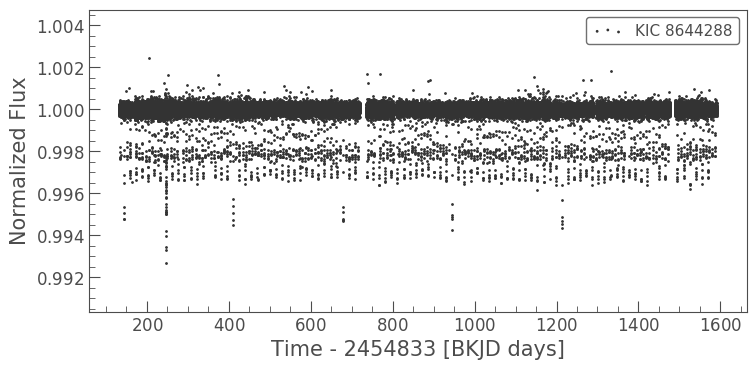

In [9]:
# detrend long cadence data
print('detrending long cadence data')
lc_pdcsap = wings.detrend_and_join(lc_rawdata_list, masklist=lc_mask_list)
lc_pdcsap.scatter()

lc_time  = lc_pdcsap.time
lc_flux  = lc_pdcsap.flux
lc_error = lc_pdcsap.flux_err


# detrend short cadence data (don't plot with lk.scatter -- there's too much data!)
print('detrending short cadence data')
sc_pdcsap = wings.detrend_and_join(sc_rawdata_list, window_length=3001, break_tolerance=750, masklist=sc_mask_list)

sc_time  = sc_pdcsap.time
sc_flux  = sc_pdcsap.flux
sc_error = sc_pdcsap.flux_err


In [10]:
# remove some manually identified bad cadences in pre-specified ranges
print('removing pre-identified bad cadences')

lc_manual_mask = np.zeros_like(lc_time, dtype='bool')
sc_manual_mask = np.zeros_like(sc_time, dtype='bool')

if BAD_CADENCES is not None:
    for bc in BAD_CADENCES:
        lc_manual_mask += (lc_time > bc[0])*(lc_time<bc[1])
        sc_manual_mask += (sc_time > bc[0])*(sc_time<bc[1])

# long cadence
lc_time  = lc_time[~lc_manual_mask]
lc_flux  = lc_flux[~lc_manual_mask]
lc_error = lc_error[~lc_manual_mask]

# short cadence
sc_time  = sc_time[~sc_manual_mask]
sc_flux  = sc_flux[~sc_manual_mask]
sc_error = sc_error[~sc_manual_mask]

removing pre-identified bad cadences


In [11]:
# make individual masks for where each planet transits
print('making transit masks')

lc_mask = np.zeros((NPL,len(lc_time)),dtype='bool')
sc_mask = np.zeros((NPL,len(sc_time)),dtype='bool')

for npl, p in enumerate(planets):
    lc_mask[npl] = wings.make_transitmask(p, lc_time, masksize=1.5)
    sc_mask[npl] = wings.make_transitmask(p, sc_time, masksize=1.5)


making transit masks


# Cut stamps around each transit

In [12]:
# cut stamps
print('cutting stamps')

for npl, p in enumerate(planets):
    print('\nPLANET %d, P = %.2f' %(npl+1,p.period))
    # make some masks
    thisplanet  = np.arange(NPL) == npl
    otherplanet = np.arange(NPL) != npl
    
    lc_selfmask = np.squeeze(lc_mask[thisplanet])
    sc_selfmask = np.squeeze(sc_mask[thisplanet])
    
    lc_siblingmask = np.sum(lc_mask[otherplanet],axis=0,dtype='bool')
    sc_siblingmask = np.sum(sc_mask[otherplanet],axis=0,dtype='bool')
        
    # cut long cadence stamps
    lc_time_stamps  = wings.cut_stamps(p, lc_time, lc_time)
    lc_flux_stamps  = wings.cut_stamps(p, lc_time, lc_flux)
    lc_error_stamps = wings.cut_stamps(p, lc_time, lc_error)
    lc_mask_stamps  = wings.cut_stamps(p, lc_time, lc_siblingmask)
    
    # cut short cadence stamps
    sc_time_stamps  = wings.cut_stamps(p, sc_time, sc_time)
    sc_flux_stamps  = wings.cut_stamps(p, sc_time, sc_flux)
    sc_error_stamps = wings.cut_stamps(p, sc_time, sc_error)
    sc_mask_stamps  = wings.cut_stamps(p, sc_time, sc_siblingmask)
    
    # combine SC and LC stamps
    p.time_stamps,  t_cadence = wings.combine_stamps(sc_time_stamps,  lc_time_stamps)
    p.flux_stamps,  f_cadence = wings.combine_stamps(sc_flux_stamps,  lc_flux_stamps)
    p.error_stamps, e_cadence = wings.combine_stamps(sc_error_stamps, lc_error_stamps)
    p.mask_stamps,  m_cadence = wings.combine_stamps(sc_mask_stamps,  lc_mask_stamps)
    
    checkf = np.array_equal(t_cadence, f_cadence)
    checke = np.array_equal(t_cadence, e_cadence)
    checkm = np.array_equal(t_cadence, m_cadence)
    
    if (checkf+checke+checkm) == False:
        raise ValueError('recovered stamp types do not all match')
    else:
        p.stamp_cadence = t_cadence

    # clean up the stamps
    wings.mask_overlapping_transits(p)
    wings.clip_outlier_cadences(p)
    wings.flatten_stamps(p)
    
    # pick out the good stamps
    p.calculate_stamp_coverage()    
    p.identify_good_transits(cover_fraction=0.7, chisq_sigma=20.0)

cutting stamps

PLANET 1, P = 3.50
0 out of 361 transits rejected with high chisq
20 out of 361 transits rejected with insufficient coverage

PLANET 2, P = 7.64
0 out of 166 transits rejected with high chisq
21 out of 166 transits rejected with insufficient coverage

PLANET 3, P = 14.86
0 out of 83 transits rejected with high chisq
7 out of 83 transits rejected with insufficient coverage


LONG CADENCE TRANSITS


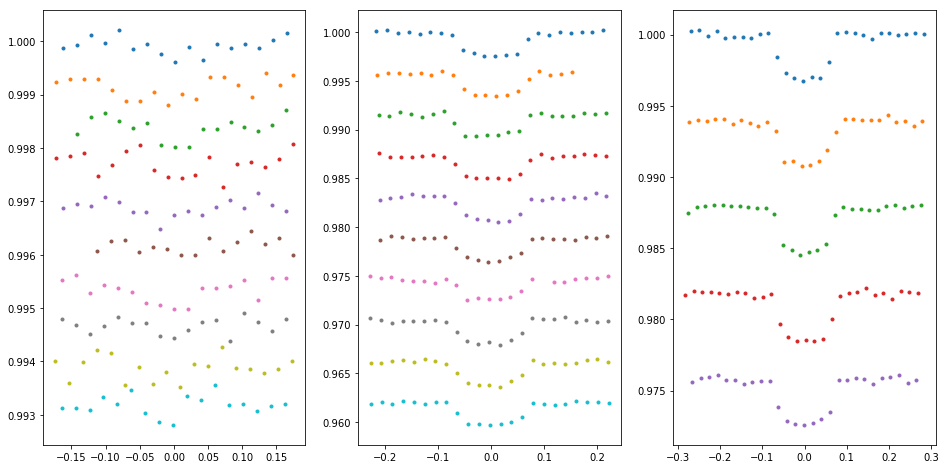

In [13]:
# display a few long cadence stamps
print('LONG CADENCE TRANSITS')
fig, axes = plt.subplots(1, NPL, figsize=(16,8))

for npl, p in enumerate(planets):
    lcts = p.grab_stamps('time', 'long')
    lcfs = p.grab_stamps('flux', 'long')
    
    tts = p.tts[p.quality*(p.stamp_cadence=='long')]
    
    ax = axes[npl]
    for i in range(np.min([10,len(lcts)])):
        ax.plot(lcts[i]-tts[i], lcfs[i]-p.depth*2*i, '.')
    
plt.show()

SHORT CADENCE TRANSITS


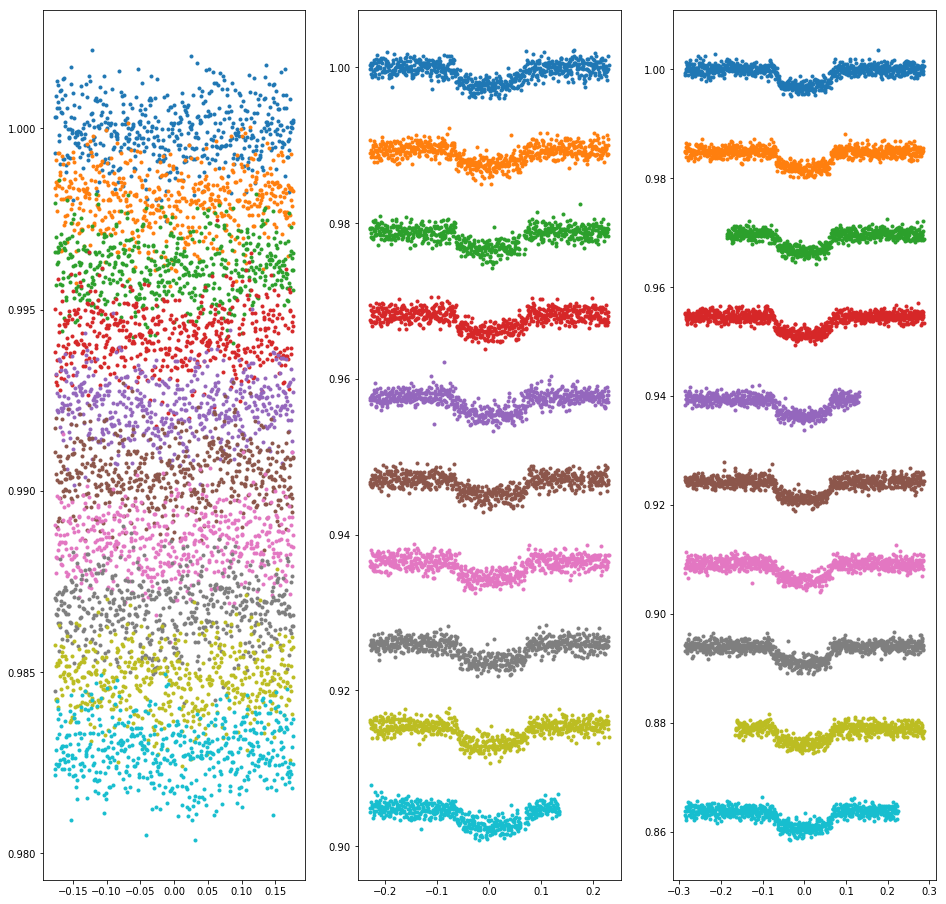

In [14]:
# display a few short cadence stamps
print('SHORT CADENCE TRANSITS')
fig, axes = plt.subplots(1, NPL, figsize=(16,16))

for npl, p in enumerate(planets):
    scts = p.grab_stamps('time', 'short')
    scfs = p.grab_stamps('flux', 'short')
    
    tts = p.tts[p.quality*(p.stamp_cadence=='short')]
    
    ax = axes[npl]
    for i in range(np.min([10,len(scts)])):
        ax.plot(scts[i]-tts[i], scfs[i]-p.depth*5*i, '.')
    
plt.show()

# Estimate correlated noise

Number of samples = 2124
Number of points per sample = 840
Number of transit-free and gap-free samples = 765


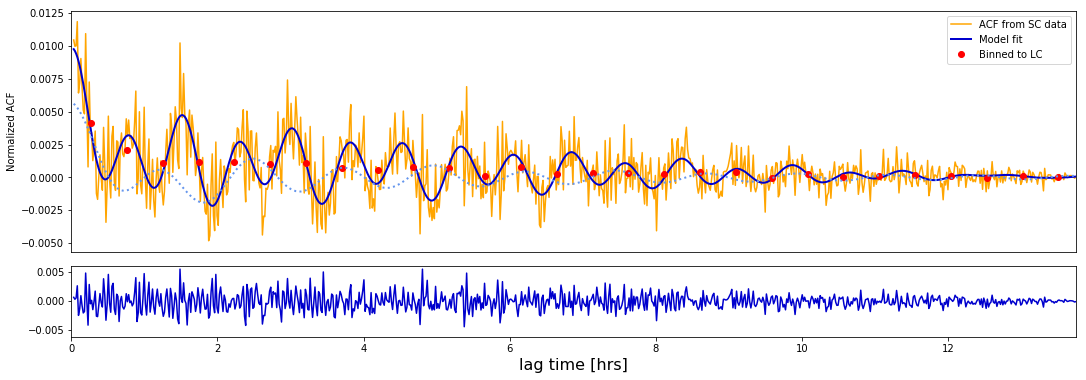

In [15]:
# make a mask where any planet transits
scm = sc_mask.sum(axis=0) > 0

# set Npts from 3 x maximum transit duration
durations = np.zeros(NPL)
for npl, p in enumerate(planets):
    durations[npl] = p.duration
Npts = int(3*durations.max()*24*3600/SCIT)

# generate the autocorrelation function
xcor, acor, wcor = wings.generate_acor_fxn(sc_time, sc_flux, scm, Npts)

# model the autocorrelation function (don't use lag-zero data)
acor_model, acor_theta = wings.model_acor_fxn(xcor[1:], acor[1:], wcor=1.0)

In [16]:
# get size of longest stamp
stamplength = []
for npl, p in enumerate(planets):
    tstamps = p.grab_stamps('time')
    
    for ts in tstamps:
        stamplength.append(int(np.round((ts[-1]-ts[0])/(SCIT/3600/24))))
        
msl = np.max(stamplength) + 1

# estimate contribution from red and white noise
sigma_white = np.median(sc_error)
sigma_tot   = np.std(sc_flux[~scm])
sigma_red   = np.sqrt(sigma_tot**2 - sigma_white**2)

print(sigma_red**2/sigma_tot**2)
print(np.sqrt(np.sum(acor[1:]**2)/acor[0]**2))
print(np.sqrt(acor[1]/acor[0]))

# make the covariance matrix
covmatrix = wings.make_covariance_matrix(xcor[1:], acor_theta, msl, sigma_white, sigma_red)

0.10119196714647377
0.06325422112392481
0.10215809199313429


In [17]:
for npl, p in enumerate(planets):
    N = len(p.tts)
    
    icov = []
    for i in range(N):
        if p.quality[i] == False:
            icov.append(None)
        else:
            cadence = p.stamp_cadence[i]
            tstamp  = p.time_stamps[i]
            estamp  = p.error_stamps[i]
            
            if cadence == 'short':
                x = np.array(np.round((tstamp-tstamp[0])/(SCIT/3600/24)),dtype='int')
                cm_here = covmatrix[x,:]
                cm_here = cm_here[:,x]
                icov.append(np.linalg.inv(cm_here))
            
            elif cadence == 'long':
                cm_here = np.diag(np.ones(len(estamp))*np.median(estamp)**2)
                icov.append(np.linalg.inv(cm_here))
                
    p.icov = icov

# Do a model fit

In [18]:
# initialize parameter vectors for each planet
for npl, p in enumerate(planets):
    # set up shape parameter vectors
    p.pshape = np.array([p.epoch, p.period, np.sqrt(p.depth), 1/p.duration, 0.25, 0.0355, 0.0355, U1, U2])
    
    # define ttv model
    p.ptime = np.array([p.epoch,p.period])

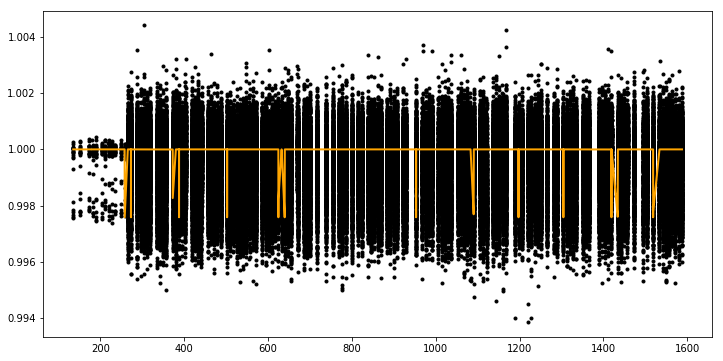

In [84]:
imp.reload(wings)

p = planets[1]
tts = p.tts[p.quality]
time_stamps = p.grab_stamps('time')
flux_stamps = p.grab_stamps('flux')
cadences = p.stamp_cadence[p.quality]

model_stamps = wings.calculate_model_flux(p.pshape, RSTAR, tts, time_stamps, cadences, orbittype='TTV')


plt.figure(figsize=(12,6))
plt.plot(np.hstack(time_stamps), np.hstack(flux_stamps), 'k.')
plt.plot(np.hstack(time_stamps), np.hstack(model_stamps), c='orange', lw=2)
plt.show()

In [24]:
for npl, p in enumerate(planets):
    print('\n\nPLANET %d, P = %.2f' %(npl+1,p.period))
    p.pshape_values(Rstar=RSTAR)



PLANET 1, P = 3.50
T0	 0.3349
P	 3.5047
rp (rE)	 2.1439
dur 	 2.8296
b	 0.5000
esinw	 0.0355
ecosw	 0.0355


PLANET 2, P = 7.64
T0	 5.5003
P	 7.6416
rp (rE)	 5.0600
dur 	 3.6692
b	 0.5000
esinw	 0.0355
ecosw	 0.0355


PLANET 3, P = 14.86
T0	 9.2837
P	 14.8589
rp (rE)	 6.0557
dur 	 4.5798
b	 0.5000
esinw	 0.0355
ecosw	 0.0355
